In [2]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, vgg16

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [4]:
%cd gdrive/MyDrive

/content/gdrive/MyDrive


 Q1b(i), (iii)

In [ ]:
arrays = []
labels = []
paths = []
path = './Colab Notebooks/DSCI552 Project/data/images'
for i, folder in enumerate(os.listdir(path)):
    if not folder.startswith('.'):
        for img in tqdm(os.listdir(os.path.join(path, folder))):
            if not img.startswith('.'):
                img_ = cv2.imread(os.path.join(path, folder, img), cv2.IMREAD_UNCHANGED)
                resized = cv2.resize(img_, (224, 224), interpolation = cv2.INTER_AREA)
                img_path = os.path.join(path, folder, img)
                arrays.append(resized)
                labels.append(folder.split('.')[1])
                paths.append(img_path)

100%|██████████| 60/60 [00:10<00:00,  5.47it/s]


In [ ]:
data = pd.DataFrame({'rbg': arrays, 'class': labels, 'path': paths})
data.head(2)

,rbg,class,path
0,"[[[232, 183, 124], [230, 181, 124], [231, 179,...",Pied_Kingfisher,./Colab Notebooks/DSCI552 Project/data/images/...
1,"[[[17, 28, 15], [16, 30, 16], [19, 34, 20], [2...",Pied_Kingfisher,./Colab Notebooks/DSCI552 Project/data/images/...


In [ ]:
onehotencoder = OneHotEncoder()
ohe_label = onehotencoder.fit_transform(data['class'].values.reshape(-1,1)).toarray()
columns = [f.split('0_')[1] for f in onehotencoder.get_feature_names_out()]
dfOneHot = pd.DataFrame(ohe_label, columns=columns) 
df = pd.concat([data, dfOneHot], axis=1)
df.sample(1)

,rbg,class,path,Class,American_Pipit,Anna_Hummingbird,Artic_Tern,Bank_Swallow,Bobolink,Brandt_Cormorant,...,Lazuli_Bunting,Olive_sided_Flycatcher,Ovenbird,Pacific_Loon,Pied_Kingfisher,Pomarine_Jaeger,Ringed_Kingfisher,Savannah_Sparrow,Scissor_tailed_Flycatcher,White_eyed_Vireo
265,"[[[89, 157, 169], [91, 159, 172], [89, 159, 17...",Anna_Hummingbird,./Colab Notebooks/DSCI552 Project/data/images/...,6,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Q1b(ii)

In [ ]:
X = df[['rbg', 'path', 'class', 'Class']]
y = df.drop(['rbg', 'class', 'path', 'Class'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, stratify=y_test, test_size=0.5)

In [ ]:
directory='./Colab Notebooks/DSCI552 Project/data/train'

for i in range(len(X_train)):
    path = r'%s' % X_train.iloc[i, 1]
    class_ = X_train.iloc[i, 2]
    if class_ not in os.listdir(directory):
      os.mkdir(os.path.join(directory,class_))
    image=cv2.imread(path)
    filename = X_train.iloc[i, 1].split('/')[-1]
    cv2.imwrite(os.path.join(directory, class_, filename), image)

In [ ]:
directory='./Colab Notebooks/DSCI552 Project/data/validation'

for i in range(len(X_val)):
    path = r'%s' % X_val.iloc[i, 1]
    class_ = X_val.iloc[i, 2]
    if class_ not in os.listdir(directory):
      os.mkdir(os.path.join(directory,class_))
    image=cv2.imread(path)
    filename = X_val.iloc[i, 1].split('/')[-1]
    cv2.imwrite(os.path.join(directory, class_, filename), image)

In [ ]:
directory='./Colab Notebooks/DSCI552 Project/data/test'

for i in range(len(X_test)):
    path = r'%s' % X_test.iloc[i, 1]
    class_ = X_test.iloc[i, 2]
    if class_ not in os.listdir(directory):
      os.mkdir(os.path.join(directory,class_))
    image=cv2.imread(path)
    filename = X_test.iloc[i, 1].split('/')[-1]
    cv2.imwrite(os.path.join(directory, class_, filename), image)

Q1b(iii)

In [ ]:
train_datagen = ImageDataGenerator(
                                  zoom_range=random.uniform(0.4, 0.6),
                                  shear_range = 0.2,
                                  rotation_range=30,
                                  horizontal_flip=True,
                                  brightness_range=[0.2, 1.0],
                                  height_shift_range=0.2,
                                  width_shift_range = 0.2,
                                )

test_datagen = ImageDataGenerator()

In [ ]:
train_generator = train_datagen.flow_from_directory(
    directory='./Colab Notebooks/DSCI552 Project/data/train',
    target_size=(224, 224),
    batch_size=16,
    class_mode="categorical",
    shuffle=True,
    seed=0
)

valid_generator = test_datagen.flow_from_directory(
    directory='./Colab Notebooks/DSCI552 Project/data/validation/',
    target_size=(224, 224),
    batch_size=16,
    class_mode="categorical",
    shuffle=True,
    seed=0
)

test_generator = test_datagen.flow_from_directory(
    directory='./Colab Notebooks/DSCI552 Project/data/test',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False,
    seed=0
)

Found 823 images belonging to 20 classes.
Found 176 images belonging to 20 classes.
Found 177 images belonging to 20 classes.


1c(i), (ii), (iii), (iv)

EfficientNetB0

In [ ]:
base_model_B0 = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model_B0.trainable = False # freeze weights

In [ ]:
model = models.Sequential()
model.add(base_model_B0)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(20, activation="softmax"))

In [ ]:
model.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=["acc"]
)

In [ ]:
filepath="/content/gdrive/MyDrive/best_model_B0.hdf5"
callback = [
    EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True),
    ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
]
callbacks_list = [callback]

In [ ]:
model1 = model.fit_generator(
    generator=train_generator,
    epochs=50,
    validation_data=valid_generator,
    callbacks=callbacks_list,
)

<ipython-input-77-05bf14c67acb>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model1 = model.fit_generator(


Epoch 1/50
52/52 [==============================] - ETA: 0s - loss: 1.6280 - acc: 0.5237
Epoch 1: val_loss improved from inf to 0.91327, saving model to /content/gdrive/MyDrive/best_model_B0.hdf5
52/52 [==============================] - 87s 2s/step - loss: 1.6280 - acc: 0.5237 - val_loss: 0.9133 - val_acc: 0.8011
Epoch 2/50
52/52 [==============================] - ETA: 0s - loss: 0.7512 - acc: 0.7728
Epoch 2: val_loss improved from 0.91327 to 0.68681, saving model to /content/gdrive/MyDrive/best_model_B0.hdf5
52/52 [==============================] - 69s 1s/step - loss: 0.7512 - acc: 0.7728 - val_loss: 0.6868 - val_acc: 0.8239
Epoch 3/50
52/52 [==============================] - ETA: 0s - loss: 0.5945 - acc: 0.8165
Epoch 3: val_loss improved from 0.68681 to 0.56784, saving model to /content/gdrive/MyDrive/best_model_B0.hdf5
52/52 [==============================] - 78s 1s/step - loss: 0.5945 - acc: 0.8165 - val_loss: 0.5678 - val_acc: 0.8352
Epoch 4/50
52/52 [=============================

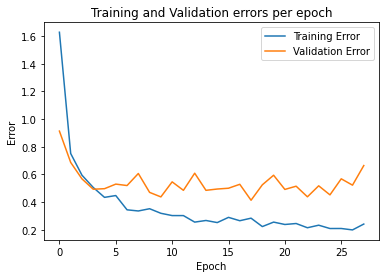

In [ ]:
epochs = [i for i in range(len(model1.history['loss']))]
plt.plot(epochs, model1.history['loss'])
plt.plot(epochs, model1.history['val_loss'])
plt.title('Training and Validation errors per epoch')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(['Training Error', 'Validation Error'])
plt.show()

In [ ]:
model.load_weights('/content/gdrive/MyDrive/best_model_B0.hdf5')

In [ ]:
y_pred = model.predict(test_generator)

12/12 [==============================] - 15s 1s/step


In [ ]:
y_pred1 = np.argmax(y_pred, axis=1)

VGG16

In [ ]:
train_datagen2 = ImageDataGenerator(
    zoom_range=random.uniform(0.4, 0.6),
    shear_range = 0.2,
    rotation_range=30,
    horizontal_flip=True,
    brightness_range=[0.2, 1.0],
    height_shift_range=0.2,
    width_shift_range = 0.2,
    preprocessing_function=preprocess_input
)

test_datagen2 = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_generator2 = train_datagen2.flow_from_directory(
    directory='./Colab Notebooks/DSCI552 Project/data/train',
    target_size=(224, 224),
    batch_size=16,
    class_mode="categorical",
    shuffle=True,
    seed=0
)

valid_generator2 = test_datagen2.flow_from_directory(
    directory='./Colab Notebooks/DSCI552 Project/data/validation/',
    target_size=(224, 224),
    batch_size=16,
    class_mode="categorical",
    shuffle=True,
    seed=0
)

test_generator2 = test_datagen2.flow_from_directory(
    directory='./Colab Notebooks/DSCI552 Project/data/test',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False,
    seed=0
)

Found 823 images belonging to 20 classes.
Found 176 images belonging to 20 classes.
Found 177 images belonging to 20 classes.


In [ ]:
base_model_vgg = vgg16.VGG16(include_top=False, weights="imagenet")
base_model_vgg.trainable = False # freeze weights

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
model_ = models.Sequential()
model_.add(base_model_vgg)
model_.add(layers.GlobalMaxPooling2D())
model_.add(layers.Dropout(0.2))
model_.add(layers.Dense(256, activation='relu'))
model_.add(layers.BatchNormalization())
model_.add(layers.Dense(20, activation="softmax"))

In [ ]:
model_.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=["acc"]
)

In [ ]:
filepath2="/content/gdrive/MyDrive/best_model_vgg.hdf5"
callback2 = [
    EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True),
    ModelCheckpoint(filepath2, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
]
callbacks_list2 = [callback2]

In [ ]:
model2 = model_.fit_generator(
    generator=train_generator2,
    epochs=50,
    validation_data=valid_generator2,
    callbacks=callbacks_list2,
)

<ipython-input-14-58e3a3851320>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model2 = model_.fit_generator(


Epoch 1/50
52/52 [==============================] - ETA: 0s - loss: 2.5268 - acc: 0.2685 
Epoch 1: val_loss improved from inf to 1.81071, saving model to /content/gdrive/MyDrive/best_model_vgg.hdf5
52/52 [==============================] - 747s 14s/step - loss: 2.5268 - acc: 0.2685 - val_loss: 1.8107 - val_acc: 0.5511
Epoch 2/50
52/52 [==============================] - ETA: 0s - loss: 1.4385 - acc: 0.5541
Epoch 2: val_loss improved from 1.81071 to 1.23834, saving model to /content/gdrive/MyDrive/best_model_vgg.hdf5
52/52 [==============================] - 19s 365ms/step - loss: 1.4385 - acc: 0.5541 - val_loss: 1.2383 - val_acc: 0.6818
Epoch 3/50
52/52 [==============================] - ETA: 0s - loss: 1.0972 - acc: 0.6756
Epoch 3: val_loss improved from 1.23834 to 0.97532, saving model to /content/gdrive/MyDrive/best_model_vgg.hdf5
52/52 [==============================] - 18s 343ms/step - loss: 1.0972 - acc: 0.6756 - val_loss: 0.9753 - val_acc: 0.7330
Epoch 4/50
52/52 [=================

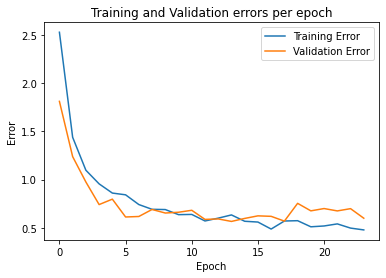

In [ ]:
epochs = [i for i in range(len(model2.history['loss']))]
plt.plot(epochs, model2.history['loss'])
plt.plot(epochs, model2.history['val_loss'])
plt.title('Training and Validation errors per epoch')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(['Training Error', 'Validation Error'])
plt.show()

In [ ]:
model_.load_weights('/content/gdrive/MyDrive/best_model_vgg.hdf5')

In [ ]:
y_pred_ = model_.predict(test_generator2)

12/12 [==============================] - 122s 11s/step


In [ ]:
y_pred2 = np.argmax(y_pred_, axis=1)

For EfficientNetB0, epoch 18 has the lowest validation error 0.41339, so it is the best model obtained. For VGG16, epoch 14 has the lowest validation error 0.56689, so it is the best model obtained. EfficientNetB0 has higher training and validation accuracy and lower training and validation error. So, EfficientNetB0 might be a better model for this cliassification problem.

Q1c(v) Precision, Recall, and F1 score

In [ ]:
print(metrics.classification_report(test_generator.classes, y_pred1))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.89      0.89      0.89         9
           2       0.90      1.00      0.95         9
           3       0.75      0.67      0.71         9
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00         9
           6       0.90      1.00      0.95         9
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00         9
          10       1.00      0.89      0.94         9
          11       0.75      0.67      0.71         9
          12       1.00      0.89      0.94         9
          13       1.00      1.00      1.00         9
          14       1.00      0.89      0.94         9
          15       0.82      1.00      0.90         9
          16       1.00      1.00      1.00         9
          17       1.00    

In [ ]:
print(metrics.classification_report(test_generator2.classes, y_pred2))

              precision    recall  f1-score   support

           0       0.53      1.00      0.69         9
           1       1.00      0.78      0.88         9
           2       1.00      1.00      1.00         9
           3       0.80      0.44      0.57         9
           4       1.00      1.00      1.00         9
           5       1.00      0.89      0.94         9
           6       0.73      0.89      0.80         9
           7       1.00      0.83      0.91         6
           8       0.75      0.67      0.71         9
           9       1.00      1.00      1.00         9
          10       1.00      0.89      0.94         9
          11       0.67      0.67      0.67         9
          12       1.00      0.78      0.88         9
          13       0.89      0.89      0.89         9
          14       1.00      0.78      0.88         9
          15       0.62      0.89      0.73         9
          16       1.00      0.78      0.88         9
          17       0.62    

For EfficientNetB0, the precision is 0.94, recall and F1 score is 0.93. For VGG16, the precision is 0.87, recall and F1 score is 0.84. EfficientNetB0 performs better in this multi-class classification problem.